Evaluating Model Robustness to non-stationary signal when trained on stationary signal

The RoAs of seperate models trained at different variations of the non-stationarities researched is calculated and graphed

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LambdaCallback
from tensorflow.keras.models import Sequential, load_model, Model
from scipy.signal import find_peaks

In [2]:
#Recieves data and applies z-score standardisation on all channels
def standardise(stored_data):
    scaler = StandardScaler()
    standard_stored_data = scaler.fit_transform(stored_data)
    return standard_stored_data

In [3]:
#Following code was made by adapting original code by Wen et. al (2021)
#Provided in their paper: "A convolutional neural network to identify motor units
#from high-density surface electromyography signals inreal time"
#Original code can be found here: https://github.com/ywen3/dcnn_mu_decomp/blob/main/hdEMG_DCNN.ipynb

#Used for calculating RoA during model training

def RoA_m(y_true, y_pred):
    threshold = 3*tf.math.reduce_std(y_pred)
    y_pred_binary = tf.where(y_pred>=threshold, 1., 0.)
    y_comp = y_pred_binary + y_true
    true_positives = tf.shape(tf.where(y_comp == 2))[0]
    unmatched = tf.shape(tf.where(y_comp == 1))[0]
    return true_positives/(true_positives + unmatched)


class AccuracyCallback(Callback):
    def __init__(self, metric_name = 'accuracy'):
        super().__init__()
        self.metric_name = metric_name
        self.val_metric = []
        self.metric = []
        self.val_metric_mean = 0
        self.metric_mean = 0
        self.best_metric = 0
        
    def on_epoch_end(self, epoch, logs=None):
#         print('Accuracycallback')
        # extract values from logs
        self.val_metric = []
        self.metric = []
        for log_name, log_value in logs.items():
            if log_name.find(self.metric_name) != -1:
                if log_name.find('val') != -1:
                    self.val_metric.append(log_value)
                else:
                    self.metric.append(log_value)

        self.val_metric_mean = np.mean(self.val_metric)
        self.metric_mean = np.mean(self.metric)
        logs['val_{}'.format(self.metric_name)] = np.mean(self.val_metric)   # replace it with your metrics
        logs['{}'.format(self.metric_name)] = np.mean(self.metric)   # replace it with your metrics

In [4]:
#Calculate the RoA given model predictions and true labels Y
def singleModelRoA(predictions, Y):
    y_pred = tf.squeeze(predictions)
    threshold = 3*np.std(y_pred,axis = 1)
    match = 0
    unmatch = 0
    for MU in range(len(Y)):
        pred_spikes, _ = find_peaks(y_pred[MU], height = threshold[MU], distance = 2)
        true_spikes = tf.squeeze(tf.where(np.array(Y)[MU] == 1))
        a = set(true_spikes.numpy())
        b = set(pred_spikes)
        matches = len(a.intersection(b))
        unmatched1 = a - b
        unmatched2 = b - a
        tolerance = len([x for x in unmatched1 if (x+1 in unmatched2 or x-1 in unmatched2)])
        match = match + matches + tolerance
        unmatch = unmatch + len(unmatched1) + len(unmatched2) - (2*tolerance)
    return match/(match + unmatch)

In [5]:
#Function for windowing test signal, predictions are recieved 
#from the model in batches to limit memory issues
def windowtest(EMGtrain, spiketrain, window_size, model):
    
    EMGtrain = standardise(EMGtrain)
    x_train = []
    y_train = []
    predictions = []
    count = 1
    for i in range(30,EMGtrain.shape[0]-120):
        x_train.append(EMGtrain[i-10:i+(window_size-10),:])
        y_train.append(spiketrain[i, 0:5])
        if count%8162 == 0:
            predictions.append(model(np.array(x_train)))
            x_train = []
        count = count + 1
            
    y_train = np.array(y_train)
    
    return tf.concat(predictions, axis = 1), y_train.T

In [7]:
#Gets a matrix saving the different RoAs achieved by the models
#Structure: (Signal model trained on, Signal model tested on, test fold)
def getRoAsOverNoise(var, noises):
    RoAs = np.zeros((5,5,5))
    for fold in [1,2,3,4,5]:
        count1 = 0
        for n in noises:
            conv_model2 = load_model('{}_models/bestvR_{}_fold{}.h5'.format(var,n, fold), custom_objects={"RoA_m": RoA_m})
            count2 = 0
            for noise in noises:
                EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, noise, fold))
                spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, noise, fold))
                predictions, Y = windowtest(EMGtest, spikes, 60, conv_model2)
                RoAs[count1, count2, fold-1] = singleModelRoA(predictions, Y)
                count2 = count2 + 1
            count1 = count1 + 1
    return RoAs

Get robustness results and store

In [8]:
var = 'noise'
noises = ['20dB','15dB','10dB','5dB','0dB']
RoAs_noise = getRoAsOverNoise(var, noises)
np.save('Results/Robustness/RoAs_{}'.format(var),RoAs_noise)

In [ ]:
var = 'MUs'
noises = ['10MUs','20MUs','30MUs','40MUs','50MUs']
RoAs_MUs = getRoAsOverNoise(var, noises)
np.save('Results/Robustness/RoAs_{}'.format(var),RoAs_MUs)

In [ ]:
var = 'lowpass'
noises = ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz']
RoAs_lowpass = getRoAsOverNoise(var, noises)
np.save('Results/Robustness/RoAs_{}'.format(var),RoAs_lowpass)

In [ ]:
var = 'shift'
noises = ['0mm','2mm','4mm','6mm','8mm']
RoAs_shift = getRoAsOverNoise(var, noises)
np.save('Results/Robustness/RoAs_{}'.format(var),RoAs_shift)

Get graphs of RoA results calculated above

In [3]:
#Get the median and IQR of the RoAs over test folds
def medErrorRobustness(RoAs):
    med = np.median(RoAs, axis = 2)
    errors = []
    for n in range(med.shape[0]):
        errors.append(abs(np.percentile(RoAs[n], [25, 75], axis = 1) - med[n]))
    return med*100, np.array(errors)*100

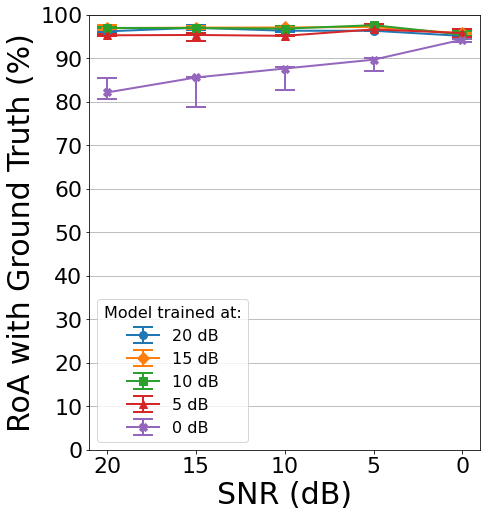

In [5]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(7, 8))
noises = ['20 dB','15 dB','10 dB','5 dB','0 dB']
noises_int = [20,15,10,5,0]

med, errors = medErrorRobustness(np.load('Results/Robustness/RoAs_noise.npy'))
markers = ['o-','D-','s-','^-','X-']
for n in range(med.shape[0]):
    plt.errorbar(noises_int,med[n].T,yerr=errors[n],fmt=markers[n], markersize = 8, capsize=10, linewidth = 2, capthick = 2)
    
plt.axis([max(noises_int)+1,min(noises_int)-1,0,100])
plt.xlabel('SNR (dB)', fontsize = '30')
plt.ylabel('RoA with Ground Truth (%)', fontsize = 30)
plt.legend(noises, title="Model trained at:",fontsize=16, title_fontsize=16)
plt.xticks(noises_int)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(axis="y")
plt.show()

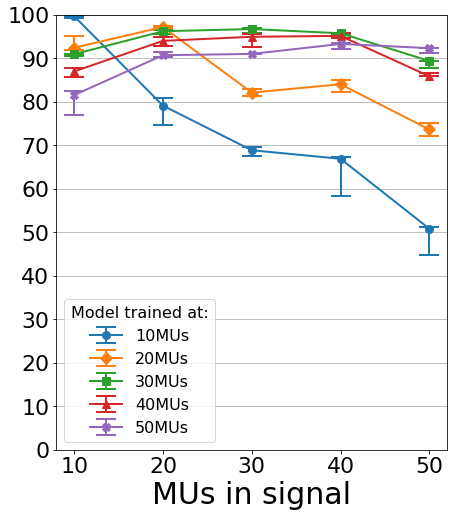

In [6]:
plt.figure(figsize=(7, 8))
noises = ['10MUs','20MUs', '30MUs', '40MUs', '50MUs']
noises_int = [10,20,30,40,50]

med, errors = medErrorRobustness(np.load('Results/Robustness/RoAs_MUs.npy'))
markers = ['o-','D-','s-','^-','X-']
for n in range(med.shape[0]):
    plt.errorbar(noises_int,med[n].T,yerr=errors[n],fmt=markers[n], markersize = 8, capsize=10, linewidth = 2, capthick = 2)

plt.axis([min(noises_int)-2,max(noises_int)+2,0,100])
plt.xlabel('MUs in signal', fontsize = 30)
plt.legend(noises, title="Model trained at:", fontsize=16, title_fontsize=16)
plt.xticks(noises_int, noises_int)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(axis="y")
plt.show()

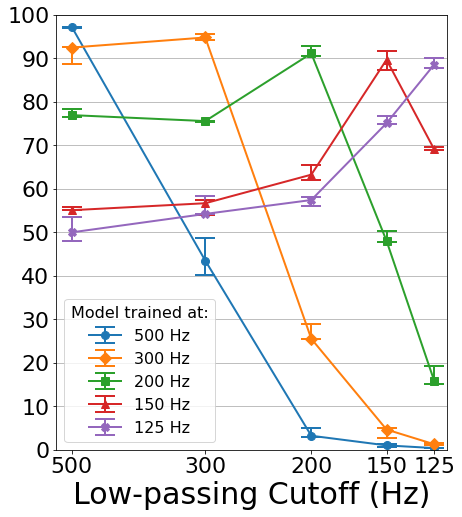

In [7]:
plt.figure(figsize=(7, 8))
noises = ['500 Hz', '300 Hz', '200 Hz', '150 Hz', '125 Hz']
noises_int = [500,300,200,150,125]

med, errors = medErrorRobustness(np.load('Results/Robustness/RoAs_lowpass.npy'))
markers = ['o-','D-','s-','^-','X-']
for n in range(med.shape[0]):
    plt.errorbar(noises_int,med[n].T,yerr=errors[n],fmt=markers[n], markersize = 8, capsize=10, linewidth = 2, capthick = 2)

plt.axis([max(noises_int)+30,min(noises_int)-6,0,100])
plt.xlabel('Low-passing Cutoff (Hz)', fontsize = '30')
plt.legend(noises, title="Model trained at:", fontsize=16, title_fontsize=16)
plt.xscale('log')
plt.xticks(noises_int, noises_int)
plt.minorticks_off()
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(axis="y")
plt.show()

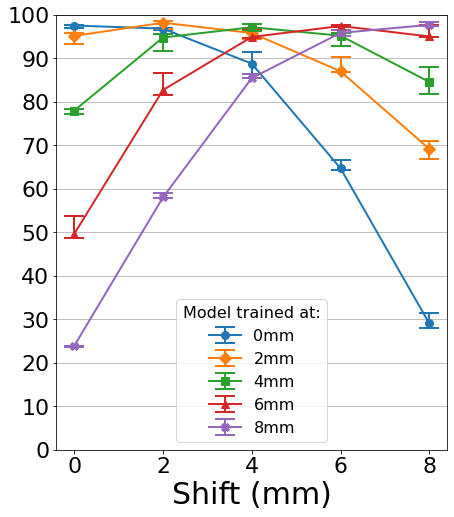

In [59]:
plt.figure(figsize=(7, 8))
noises = ['0mm','2mm', '4mm', '6mm', '8mm']
noises_int = [0,2,4,6,8]

med, errors = medErrorRobustness(np.load('Results/Robustness/RoAs_shift.npy'))
markers = ['o-','D-','s-','^-','X-']
for n in range(med.shape[0]):
    plt.errorbar(noises_int,med[n].T,yerr=errors[n],fmt=markers[n], markersize = 8, capsize=10, linewidth = 2, capthick = 2)

plt.axis([min(noises_int)-.4,max(noises_int)+.4,0,100])
plt.xlabel('Shift (mm)', fontsize = 30)
plt.legend(noises, title="Model trained at:",  fontsize=16, title_fontsize=16)
plt.xticks(noises_int, noises_int)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(axis="y")
plt.show()